<a href="https://colab.research.google.com/github/mohamedhamdy9707-byte/MEDICALSEGMENTATION/blob/main/Swin_UNETR_BTCV_Multi_organ_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U "huggingface_hub[cli]"

In [ ]:
!pip install monai[all]

In [ ]:
!hf download MONAI/swin_unetr_btcv_segmentation --local-dir ./zoo_dir/swin_unetr_btcv_segmentation/

Fetching 12 files: 100% 12/12 [00:00<00:00, 7158.53it/s]
/content/zoo_dir/swin_unetr_btcv_segmentation


In [ ]:
import torch
from monai.networks.nets import SwinUNETR

# Define model
model = SwinUNETR(
    spatial_dims=3,
     #(This was from GPT and it resulted in an error. You may uncomment it to see the error)
     #But in brief, the parameter img_size does not exist as an argument for the class SwinUNETR
    #img_size=96,
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=False,
)


In [ ]:
#Try removing the map location and checking out the error. Then try to ask gpt why it happens
state_dict = torch.load("/content/zoo_dir/swin_unetr_btcv_segmentation/models/model.pt", map_location=torch.device('cpu'))
print(state_dict.keys())

odict_keys(['swinViT.patch_embed.proj.weight', 'swinViT.patch_embed.proj.bias', 'swinViT.layers1.0.blocks.0.norm1.weight', 'swinViT.layers1.0.blocks.0.norm1.bias', 'swinViT.layers1.0.blocks.0.attn.relative_position_bias_table', 'swinViT.layers1.0.blocks.0.attn.relative_position_index', 'swinViT.layers1.0.blocks.0.attn.qkv.weight', 'swinViT.layers1.0.blocks.0.attn.qkv.bias', 'swinViT.layers1.0.blocks.0.attn.proj.weight', 'swinViT.layers1.0.blocks.0.attn.proj.bias', 'swinViT.layers1.0.blocks.0.norm2.weight', 'swinViT.layers1.0.blocks.0.norm2.bias', 'swinViT.layers1.0.blocks.0.mlp.linear1.weight', 'swinViT.layers1.0.blocks.0.mlp.linear1.bias', 'swinViT.layers1.0.blocks.0.mlp.linear2.weight', 'swinViT.layers1.0.blocks.0.mlp.linear2.bias', 'swinViT.layers1.0.blocks.1.norm1.weight', 'swinViT.layers1.0.blocks.1.norm1.bias', 'swinViT.layers1.0.blocks.1.attn.relative_position_bias_table', 'swinViT.layers1.0.blocks.1.attn.relative_position_index', 'swinViT.layers1.0.blocks.1.attn.qkv.weight', 's

In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
import os
import monai
import tempfile
from monai.apps import download_and_extract
from monai.bundle import ConfigParser
from monai.data import decollate_batch
from monai.handlers import MLFlowHandler
from monai.config import print_config
from monai.visualize.utils import blend_images
from monai.handlers.utils import from_engine
import tarfile
import os
import numpy as np
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
import glob
from monai.utils import first, set_determinism
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch

from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Activationsd,
    EnsureTyped
)
import torch

from monai.transforms import LoadImage

In [ ]:

root_dir = "./"
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
try:
  compressed_file = os.path.join(root_dir, "Tassk09_Spleen.tar")
  data_dir = os.path.join(root_dir, "Tassk09_Spleen")
  print(data_dir)
  if not os.path.exists(data_dir):
      download_and_extract(resource, compressed_file, root_dir, md5)
except:
  with tarfile.open(compressed_file, "r") as tar:
    tar.extractall(path=root_dir)

./Tassk09_Spleen
2025-10-01 18:53:20,678 - INFO - Verified 'Tassk09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-10-01 18:53:20,679 - INFO - File exists: Tassk09_Spleen.tar, skipped downloading.
2025-10-01 18:53:20,681 - INFO - Writing into directory: ./.


Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.


In [ ]:
import os
import glob
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    EnsureTyped,
)

image_key = "image"

preprocessing = Compose([
    LoadImaged(keys=image_key, reader="ITKReader"),
    EnsureChannelFirstd(keys=image_key),
    Orientationd(keys=image_key, axcodes="RAS"),
    Spacingd(keys=image_key, pixdim=(1.5, 1.5, 2), mode="bilinear"), # Increased z-spacing
    ScaleIntensityRanged(
        keys=image_key,
        a_min=-175,
        a_max=250,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    EnsureTyped(keys=image_key),
])

#This part is copied from the notebook: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb

#Simply, we are taking all the image files in the imageTs folder in the Task09_Spleen folder and getting their paths
#We then create a dataset that takes those nii files and applies the preprocessing transforms to them
#Then we create a dataloader that loads the iamges from this dataset
test_images = sorted(glob.glob(os.path.join("Task09_Spleen", "imagesTr", "*.nii.gz")))
test_data = [{"image": image} for image in test_images]
test_org_ds = Dataset(data=test_data, transform=preprocessing)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
from monai.transforms import (
    Compose,
    Activationsd,
    Invertd,
    AsDiscreted,
    SaveImaged,
)

# Example placeholders – replace with your actual values
output_dir = "./outputs"
output_ext = ".nii.gz"
output_dtype = "uint8"
output_postfix = "seg"
separate_folder = False
image_key = "image"

# Postprocessing pipeline
postprocessing = Compose([
    Activationsd(keys="pred", softmax=True),
    Invertd(
        keys="pred",
        transform=preprocessing,  # reuse your preprocessing pipeline
        orig_keys=image_key,
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True),
    SaveImaged(
        keys="pred",
        output_dir=output_dir,
        output_ext=output_ext,
        output_dtype=output_dtype,
        output_postfix=output_postfix,
        separate_folder=separate_folder,
    ),
])


Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


2025-10-01 18:54:19,378 INFO image_writer.py:197 - writing: outputs/spleen_10_seg.nii.gz


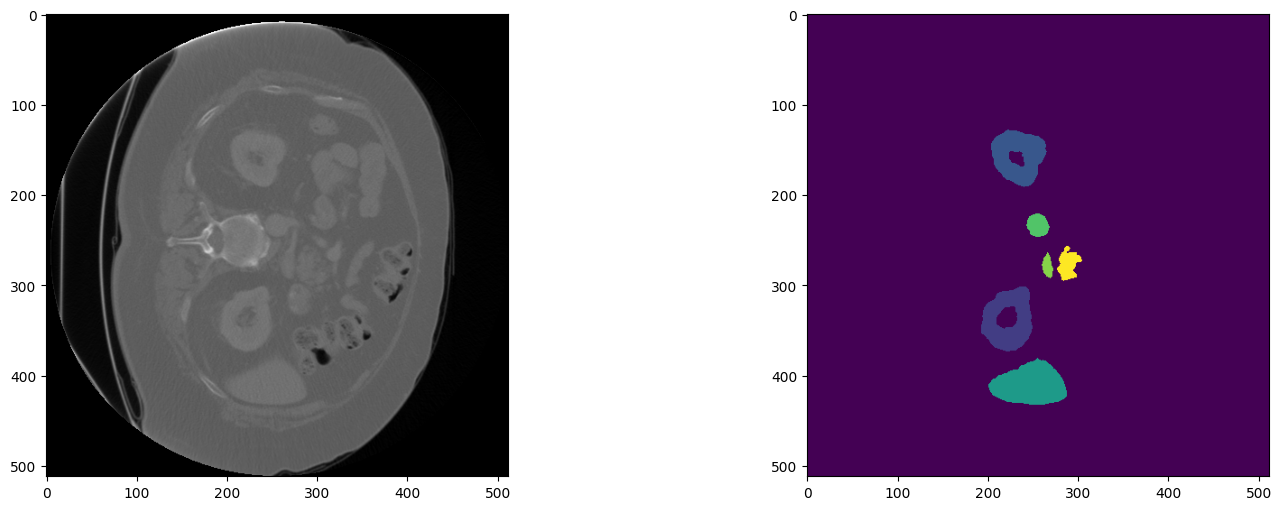

In [ ]:
loader = LoadImage()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move model to the selected device

model.eval()
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (96, 96, 96)
        sw_batch_size = 1 #Set to one for minimizing time
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.5)

        test_data = [postprocessing(i) for i in decollate_batch(test_data)]
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[0, :, :, 20])
        plt.show()
        break;

In [ ]:
test_output[0].detach().cpu().shape #1 batch, width=512 pixels, height=512 pixels, number of slices = 34

torch.Size([1, 512, 512, 55])

In [ ]:
print(test_images[0])

Task09_Spleen/imagesTr/spleen_10.nii.gz


In [ ]:
import pickle
with open("masks.pkl", "wb") as f:
    pickle.dump(test_output[0].detach().cpu()[0,:,:,:], f)

In [ ]:
with open("masks.pkl", "rb") as f:
    mask = pickle.load(f)

In [ ]:
print(mask.shape)

torch.Size([512, 512, 55])


Image shape: (512, 512, 55)


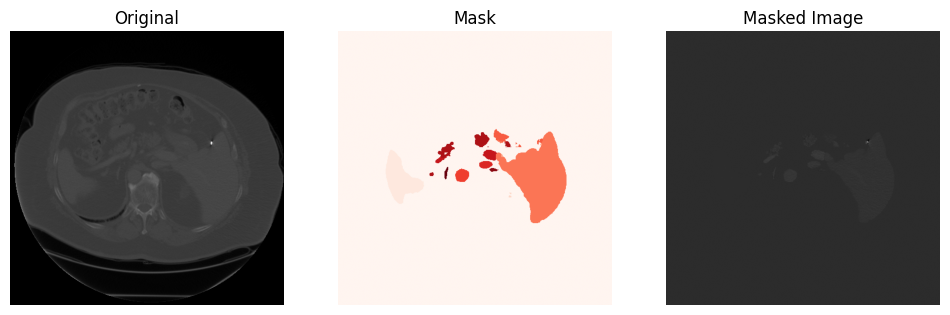

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# --------------------
# 1. Load the NIfTI file
# --------------------
img = nib.load("Task09_Spleen/imagesTr/spleen_10.nii.gz")
img_data = img.get_fdata()   # shape: (W, H, S)

print("Image shape:", img_data.shape)

# --------------------
# 3. Apply mask
# --------------------
masked_img = img_data * mask  # element-wise masking

# --------------------
# 4. Visualize a slice
# --------------------
slice_idx = img_data.shape[2] // 2  # middle slice along axial plane

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask[:, :, slice_idx].T, cmap="Reds", origin="lower")
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(masked_img[:, :, slice_idx].T, cmap="gray", origin="lower")
plt.title("Masked Image")
plt.axis("off")

plt.show()


Loading data...
Image shape: (512, 512, 55)
Prediction shape: (512, 512, 55)
Ground truth shape: (512, 512, 55)

Calculating metrics...

Dice Score: 0.9476
IoU (Jaccard): 0.9005
Hausdorff Distance 95: 2.00 mm

Generating visualizations...

✓ Visualization saved to: complete_evaluation.png


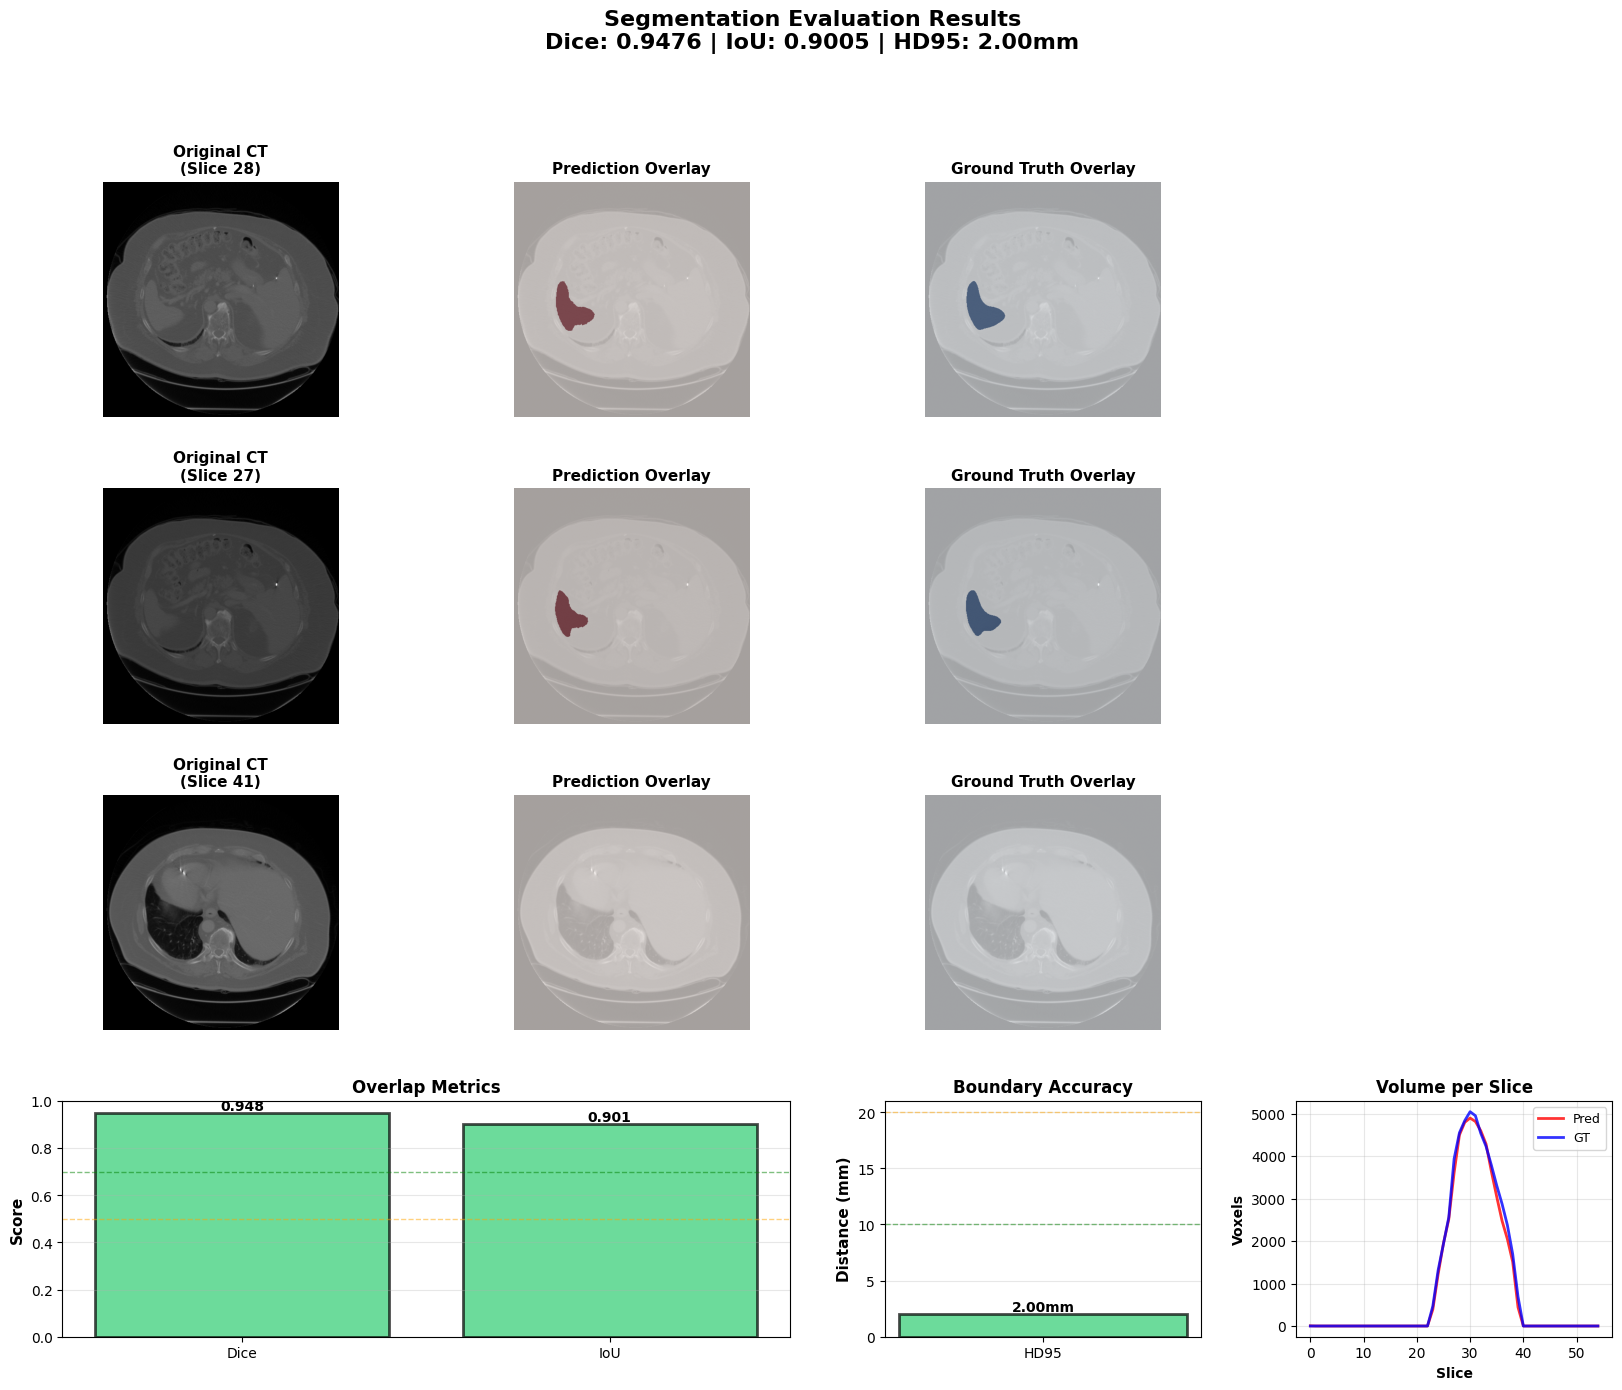


EVALUATION COMPLETE!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import pickle
from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist

# ============================================================================
# CONFIGURATION - MODIFY THESE PATHS
# ============================================================================

# Path to your predicted mask (saved from your inference)
PRED_MASK_PATH = "masks.pkl"

# Path to original image
ORIGINAL_IMAGE_PATH = "Task09_Spleen/imagesTr/spleen_10.nii.gz"  # Changed to training set

# Path to ground truth label (MODIFY THIS - use training set labels)
GROUND_TRUTH_PATH = "Task09_Spleen/labelsTr/spleen_10.nii.gz"  # Changed to training set

ORGAN_LABEL =1

# Voxel spacing for distance calculations (from your preprocessing)
SPACING = (1.5, 1.5, 2.0)

# ============================================================================
# METRIC FUNCTIONS
# ============================================================================

def dice_coefficient(pred, target):
    pred = (pred > 0).astype(np.float32)
    target = (target > 0).astype(np.float32)
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target)
    return (2.0 * intersection) / union if union > 0 else 1.0

def iou_score(pred, target):
    pred = (pred > 0).astype(np.float32)
    target = (target > 0).astype(np.float32)
    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection
    return intersection / union if union > 0 else 1.0

def hausdorff_distance_95(pred, target, spacing=(1.5, 1.5, 2.0)):
    pred = (pred > 0).astype(np.uint8)
    target = (target > 0).astype(np.uint8)

    # Get surface points
    pred_eroded = binary_erosion(pred)
    target_eroded = binary_erosion(target)
    pred_surface = pred.astype(np.int32) - pred_eroded.astype(np.int32)
    target_surface = target.astype(np.int32) - target_eroded.astype(np.int32)

    pred_pts = np.argwhere(pred_surface > 0) * np.array(spacing)
    target_pts = np.argwhere(target_surface > 0) * np.array(spacing)

    if len(pred_pts) == 0 or len(target_pts) == 0:
        return float('inf')

    dist_1 = np.min(cdist(pred_pts, target_pts), axis=1)
    dist_2 = np.min(cdist(target_pts, pred_pts), axis=1)

    return max(np.percentile(dist_1, 95), np.percentile(dist_2, 95))

# ============================================================================
# LOAD DATA
# ============================================================================

print("Loading data...")

# Load predicted mask
with open(PRED_MASK_PATH, "rb") as f:
    pred_mask = pickle.load(f)
if torch.is_tensor(pred_mask):
    pred_mask = pred_mask.cpu().numpy()

# Load original image
img = nib.load(ORIGINAL_IMAGE_PATH)
original_image = img.get_fdata()

# Load ground truth
gt_img = nib.load(GROUND_TRUTH_PATH)
ground_truth = gt_img.get_fdata()

# Extract specific organ
pred_organ = (pred_mask == ORGAN_LABEL).astype(np.uint8)
gt_organ = (ground_truth == ORGAN_LABEL).astype(np.uint8)

print(f"Image shape: {original_image.shape}")
print(f"Prediction shape: {pred_organ.shape}")
print(f"Ground truth shape: {gt_organ.shape}")

# ============================================================================
# CALCULATE METRICS
# ============================================================================

print("\nCalculating metrics...")
dice = dice_coefficient(pred_organ, gt_organ)
iou = iou_score(pred_organ, gt_organ)
hd95 = hausdorff_distance_95(pred_organ, gt_organ, SPACING)

metrics = {
    'Dice Score': dice,
    'IoU (Jaccard)': iou,
    'Hausdorff Distance 95': hd95
}

print(f"\nDice Score: {dice:.4f}")
print(f"IoU (Jaccard): {iou:.4f}")
print(f"Hausdorff Distance 95: {hd95:.2f} mm")

# ============================================================================
# VISUALIZATION
# ============================================================================

print("\nGenerating visualizations...")

# Select representative slices
num_slices = original_image.shape[2]
slice_indices = [num_slices // 2 +1 , num_slices // 2, 3 * num_slices // 4]

# Create main figure
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# ============================================================================
# ROW 1-3: SLICE VISUALIZATIONS
# ============================================================================

for i, slice_idx in enumerate(slice_indices):
    # Original image
    ax1 = fig.add_subplot(gs[i, 0])
    ax1.imshow(original_image[:, :, slice_idx].T, cmap='gray', origin='lower')
    ax1.set_title(f'Original CT\n(Slice {slice_idx})', fontsize=11, fontweight='bold')
    ax1.axis('off')

    # Prediction overlay
    ax2 = fig.add_subplot(gs[i, 1])
    ax2.imshow(original_image[:, :, slice_idx].T, cmap='gray', origin='lower', alpha=0.7)
    ax2.imshow(pred_organ[:, :, slice_idx].T, cmap='Reds', origin='lower', alpha=0.5)
    ax2.set_title('Prediction Overlay', fontsize=11, fontweight='bold')
    ax2.axis('off')

    # Ground truth overlay
    ax3 = fig.add_subplot(gs[i, 2])
    ax3.imshow(original_image[:, :, slice_idx].T, cmap='gray', origin='lower', alpha=0.7)
    ax3.imshow(gt_organ[:, :, slice_idx].T, cmap='Blues', origin='lower', alpha=0.5)
    ax3.set_title('Ground Truth Overlay', fontsize=11, fontweight='bold')
    ax3.axis('off')


# ============================================================================
# ROW 4: METRICS AND STATISTICS
# ============================================================================

# Metrics bar chart
ax_metrics = fig.add_subplot(gs[3, 0:2])
metrics_names = ['Dice', 'IoU']
metrics_values = [dice, iou]
colors = ['#2ecc71' if v >= 0.7 else '#e74c3c' if v < 0.5 else '#f39c12' for v in metrics_values]
bars = ax_metrics.bar(metrics_names, metrics_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax_metrics.set_ylim([0, 1])
ax_metrics.set_ylabel('Score', fontsize=11, fontweight='bold')
ax_metrics.set_title('Overlap Metrics', fontsize=12, fontweight='bold')
ax_metrics.axhline(y=0.7, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax_metrics.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax_metrics.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax_metrics.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Hausdorff distance
ax_hd = fig.add_subplot(gs[3, 2])
color_hd = '#2ecc71' if hd95 < 10 else '#e74c3c' if hd95 > 20 else '#f39c12'
bar_hd = ax_hd.bar(['HD95'], [hd95], color=color_hd, alpha=0.7, edgecolor='black', linewidth=2)
ax_hd.set_ylabel('Distance (mm)', fontsize=11, fontweight='bold')
ax_hd.set_title('Boundary Accuracy', fontsize=12, fontweight='bold')
ax_hd.axhline(y=10, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax_hd.axhline(y=20, color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax_hd.grid(axis='y', alpha=0.3)
ax_hd.text(0, hd95, f'{hd95:.2f}mm', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Volume statistics per slice
ax_vol = fig.add_subplot(gs[3, 3])
slices = np.arange(num_slices)
pred_vols = [np.sum(pred_organ[:, :, i] > 0) for i in range(num_slices)]
gt_vols = [np.sum(gt_organ[:, :, i] > 0) for i in range(num_slices)]
ax_vol.plot(slices, pred_vols, 'r-', linewidth=2, label='Pred', alpha=0.8)
ax_vol.plot(slices, gt_vols, 'b-', linewidth=2, label='GT', alpha=0.8)
ax_vol.set_xlabel('Slice', fontsize=10, fontweight='bold')
ax_vol.set_ylabel('Voxels', fontsize=10, fontweight='bold')
ax_vol.set_title('Volume per Slice', fontsize=12, fontweight='bold')
ax_vol.legend(fontsize=9)
ax_vol.grid(True, alpha=0.3)

# Overall title
fig.suptitle(f'Segmentation Evaluation Results\nDice: {dice:.4f} | IoU: {iou:.4f} | HD95: {hd95:.2f}mm',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('complete_evaluation.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved to: complete_evaluation.png")
plt.show()

print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)

In [ ]:
import pickle
import torch
import numpy as np

PRED_MASK_PATH = "masks.pkl"

with open(PRED_MASK_PATH, "rb") as f:
    pred_mask = pickle.load(f)

if torch.is_tensor(pred_mask):
    pred_mask = pred_mask.cpu().numpy()

print("Predicted mask loaded with shape:", pred_mask.shape)

Predicted mask loaded with shape: (512, 512, 55)


In [ ]:
!pip install vedo

In [ ]:
from vedo import Volume, Mesh, settings, Plotter
from skimage.measure import marching_cubes
settings.init_colab()

organ_meshes = {}

print("Generating 3D meshes for organs...")

for label, mask in organ_masks.items():
    # Apply marching cubes to generate vertices and faces
    # Level 0.5 is used for boolean masks
    verts, faces, normals, values = marching_cubes(mask, level=0.5)

    # Create a vedo Mesh object
    mesh = Mesh([verts, faces])

    # Store the mesh, associating it with the organ label
    organ_meshes[label] = mesh
    print(f"Generated mesh for organ label: {label}")

print(f"\nGenerated {len(organ_meshes)} meshes for the identified organs.")

setting up colab environment (can take a minute) ...installing k3d... setup completed.
Generating 3D meshes for organs...
Generated mesh for organ label: 1.0
Generated mesh for organ label: 2.0
Generated mesh for organ label: 3.0
Generated mesh for organ label: 4.0
Generated mesh for organ label: 5.0
Generated mesh for organ label: 6.0
Generated mesh for organ label: 7.0
Generated mesh for organ label: 8.0
Generated mesh for organ label: 9.0
Generated mesh for organ label: 10.0
Generated mesh for organ label: 11.0
Generated mesh for organ label: 12.0
Generated mesh for organ label: 13.0

Generated 13 meshes for the identified organs.


In [ ]:
import os

output_dir_3d = "./organ_meshes_3d"
os.makedirs(output_dir_3d, exist_ok=True)

print(f"Saving 3D meshes to '{output_dir_3d}'...")

for label, mesh in organ_meshes.items():
    # Define the output filename for each mesh
    filename = os.path.join(output_dir_3d, f"organ_{int(label)}.obj")

    # Save the mesh as an OBJ file
    mesh.write(filename)
    print(f"Saved mesh for organ label {int(label)} to {filename}")

print("\nExport complete.")

Saving 3D meshes to './organ_meshes_3d'...
Saved mesh for organ label 1 to ./organ_meshes_3d/organ_1.obj
Saved mesh for organ label 2 to ./organ_meshes_3d/organ_2.obj
Saved mesh for organ label 3 to ./organ_meshes_3d/organ_3.obj
Saved mesh for organ label 4 to ./organ_meshes_3d/organ_4.obj
Saved mesh for organ label 5 to ./organ_meshes_3d/organ_5.obj
Saved mesh for organ label 6 to ./organ_meshes_3d/organ_6.obj
Saved mesh for organ label 7 to ./organ_meshes_3d/organ_7.obj
Saved mesh for organ label 8 to ./organ_meshes_3d/organ_8.obj
Saved mesh for organ label 9 to ./organ_meshes_3d/organ_9.obj
Saved mesh for organ label 10 to ./organ_meshes_3d/organ_10.obj
Saved mesh for organ label 11 to ./organ_meshes_3d/organ_11.obj
Saved mesh for organ label 12 to ./organ_meshes_3d/organ_12.obj
Saved mesh for organ label 13 to ./organ_meshes_3d/organ_13.obj

Export complete.


In [ ]:
PRED_MASK_PATH = "masks.pkl"

with open(PRED_MASK_PATH, "rb") as f:
    pred_mask = pickle.load(f)

if torch.is_tensor(pred_mask):
    pred_mask = pred_mask.cpu().numpy()

unique_labels = np.unique(pred_mask)
organ_masks = {}
for label in unique_labels:
    if label != 0:  # Exclude background label (assuming 0 is background)
        organ_masks[label] = (pred_mask == label).astype(bool)

print(f"Identified unique organ labels: {list(organ_masks.keys())}")
print(f"Created {len(organ_masks)} individual organ masks.")

Identified unique organ labels: [np.float32(1.0), np.float32(2.0), np.float32(3.0), np.float32(4.0), np.float32(5.0), np.float32(6.0), np.float32(7.0), np.float32(8.0), np.float32(9.0), np.float32(10.0), np.float32(11.0), np.float32(12.0), np.float32(13.0)]
Created 13 individual organ masks.


In [ ]:
import pyvista
from skimage.measure import marching_cubes
import numpy as np

pyvista_organ_meshes = {}

print("Generating 3D meshes for organs using PyVista...")

# Define the spacing based on your preprocessing
spacing = (1.5, 1.5, 2.0) # Use the spacing from your preprocessing

for label, mask in organ_masks.items():
    # Apply marching cubes to generate vertices and faces
    # Level 0.5 is used for boolean masks
    verts, faces, normals, values = marching_cubes(mask, level=0.5, spacing=spacing) # Apply spacing here

    # skimage marching_cubes returns faces as (N, 3) or (N, 4) arrays,
    # PyVista expects faces in a specific format: [n_points, p1, p2, ..., pn, n_points, ...].
    # We need to reshape the faces array.
    if len(faces) > 0:
        # Create a flat array where each face is preceded by the number of points in the face (3 for triangles)
        faces_pyvista = np.hstack((np.full((faces.shape[0], 1), 3), faces)).flatten()

        # Create a PyVista PolyData object
        mesh = pyvista.PolyData(verts, faces_pyvista)

        # Store the generated PyVista mesh, associating it with the organ label
        pyvista_organ_meshes[label] = mesh
        print(f"Generated mesh for organ label: {label} with {mesh.n_points} points")
    else:
        print(f"No mesh generated for organ label: {label} (no faces found)")


print(f"\nGenerated {len(pyvista_organ_meshes)} PyVista meshes for the identified organs.")

Generating 3D meshes for organs using PyVista...
Generated mesh for organ label: 1.0 with 19774 points
Generated mesh for organ label: 2.0 with 19555 points
Generated mesh for organ label: 3.0 with 23436 points
Generated mesh for organ label: 4.0 with 1270 points
Generated mesh for organ label: 5.0 with 3647 points
Generated mesh for organ label: 6.0 with 97597 points
Generated mesh for organ label: 7.0 with 32163 points
Generated mesh for organ label: 8.0 with 10769 points
Generated mesh for organ label: 9.0 with 8578 points
Generated mesh for organ label: 10.0 with 6866 points
Generated mesh for organ label: 11.0 with 11089 points
Generated mesh for organ label: 12.0 with 1548 points
Generated mesh for organ label: 13.0 with 1508 points

Generated 13 PyVista meshes for the identified organs.


In [ ]:
!pip install "pyvista[jupyter]"

In [ ]:
import pyvista as pv

# Set the plotting backend for Colab
pv.set_jupyter_backend('html')

# Create a PyVista plotter
plotter = pv.Plotter(notebook=True)

# Manually define a list of distinct colors (enough for 13 organs)
# You can replace this with a better color palette if needed
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink',
    'gray', 'olive', 'cyan', 'lime', 'teal', 'magenta'
]

# Add each organ mesh to the plotter
# Assuming 'pyvista_organ_meshes' is already defined
labels = sorted(pyvista_organ_meshes.keys()) # Sort labels to match colors consistently
for i, label in enumerate(labels):
    mesh = pyvista_organ_meshes[label]
    mesh_name = f"organ_{int(label)}"
    # Assign a color from the list
    color = colors[i % len(colors)]
    plotter.add_mesh(mesh, name=mesh_name, show_edges=False, color=color)
    print(f"Added mesh for organ label: {int(label)} as '{mesh_name}' with color {color}")


print("Added all meshes to the plotter.")
print("Proceeding to display the plot.")

# Display the plotter
plotter.show()

Added mesh for organ label: 1 as 'organ_1' with color red
Added mesh for organ label: 2 as 'organ_2' with color blue
Added mesh for organ label: 3 as 'organ_3' with color green
Added mesh for organ label: 4 as 'organ_4' with color purple
Added mesh for organ label: 5 as 'organ_5' with color orange
Added mesh for organ label: 6 as 'organ_6' with color brown
Added mesh for organ label: 7 as 'organ_7' with color pink
Added mesh for organ label: 8 as 'organ_8' with color gray
Added mesh for organ label: 9 as 'organ_9' with color olive
Added mesh for organ label: 10 as 'organ_10' with color cyan
Added mesh for organ label: 11 as 'organ_11' with color lime
Added mesh for organ label: 12 as 'organ_12' with color teal
Added mesh for organ label: 13 as 'organ_13' with color magenta
Added all meshes to the plotter.
Proceeding to display the plot.


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…